In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import odeint 
from lmfit import minimize, Parameters, Parameter, report_fit #download lmfit: https://lmfit.github.io/lmfit-py/installation.html
from scipy.signal import savgol_filter

In [2]:
df_10k = pd.read_csv ('10krace.csv')
df_sub_19_5k = pd.read_csv ('sub_19_5k.csv')
df_sub_20_5k = pd.read_csv ('sub_20_5k.csv')
df_sub_21_5k = pd.read_csv ('sub_21_5k.csv')


secs_sub_19 = df_sub_19_5k['secs'].tolist()
secs_sub_20 = df_sub_20_5k['secs'].tolist()
secs_sub_21 = df_sub_21_5k['secs'].tolist()

hr_sub_19 = df_sub_19_5k['hr'].tolist()
hr_sub_20 = df_sub_20_5k['hr'].tolist()
hr_sub_21 = df_sub_21_5k['hr'].tolist()

speed_kph_sub_19 = df_sub_19_5k['kph'].tolist()
speed_kph_sub_20 = df_sub_20_5k['kph'].tolist()
speed_kph_sub_21 = df_sub_21_5k['kph'].tolist()

df_sub_19_5k.head()

,secs,cad,hr,km,kph,nm,watts,alt,lon,lat,...,interval,lrbalance,lte,rte,lps,rps,smo2,thb,o2hb,hhb
0,1,0,107,0.001118,4.02581,0,0,-3.20,54.437095,24.531051,...,0,-255,0,0,0,0,0,0,0,0
1,2,0,108,0.003040,6.91921,0,0,-1.80,54.437114,24.531051,...,0,-255,0,0,0,0,0,0,0,0
2,3,83,108,0.006894,8.31038,0,0,-1.88,54.437152,24.531057,...,0,-255,0,0,0,0,0,0,0,0
3,4,83,108,0.010749,9.70154,0,0,-1.96,54.437189,24.531062,...,0,-255,0,0,0,0,0,0,0,0
4,5,83,108,0.014603,11.09270,0,0,-2.04,54.437227,24.531068,...,0,-255,0,0,0,0,0,0,0,0


Simply plotting my heart rate and speed data:

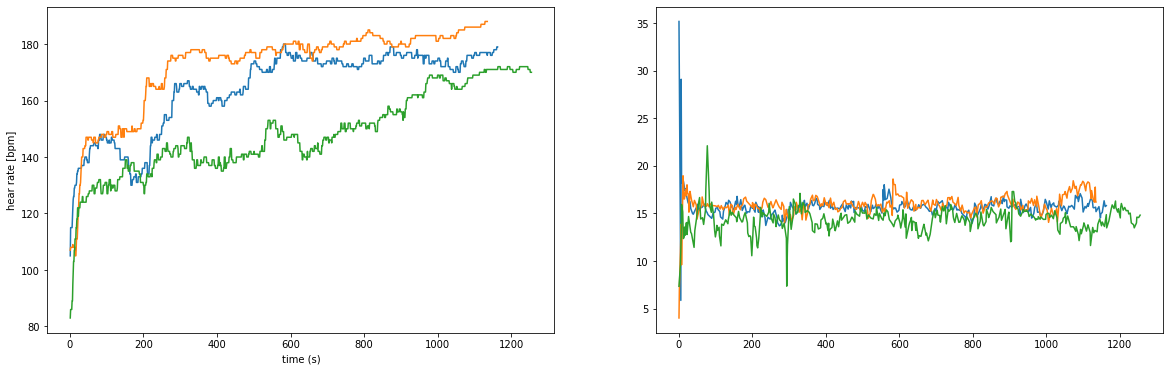

In [3]:
fig, (plt1, plt2) = plt.subplots(1, 2, figsize=(20, 6))

plt1.plot(secs_sub_20,hr_sub_20,label='heart rate')
plt1.plot(secs_sub_19,hr_sub_19,label='heart rate')
plt1.plot(secs_sub_21,hr_sub_21,label='heart rate')
plt1.set_xlabel('time (s)')
plt1.set_ylabel('hear rate [bpm]')

plt2.plot(secs_sub_20,speed_kph_sub_20)
plt2.plot(secs_sub_19,speed_kph_sub_19)
plt2.plot(secs_sub_21,speed_kph_sub_21)


In [4]:
def ode_model(X,t,a1,a2,a3,a4,a5):
    norm_speed = 1
    x1,x2 = X
    x1_dot = -a1*x1 + a2*(x2+norm_speed**2)
    phi = a4*x1/(1+np.exp(-(x1-a5)))
    x2_dot = -a3*x2 + phi
    return [x1_dot,x2_dot]

In [5]:
def ode_solver(t, initial_conditions, params):
    x1_init, x2_init = initial_conditions
    a1, a2, a3, a4, a5 = params['a1'].value, params['a2'].value, params['a3'].value, params['a4'].value, params['a5'].value
    res = odeint(ode_model, [0,0], t, args=(a1,a2,a3,a4,a5))
    return res

def error(params, initial_conditions, tspan, data):
    sol = ode_solver(tspan, initial_conditions, params)
    return (sol[:,0] - data).ravel() #I'm only interested in minimizing x1 (x2 is essentially unknown)

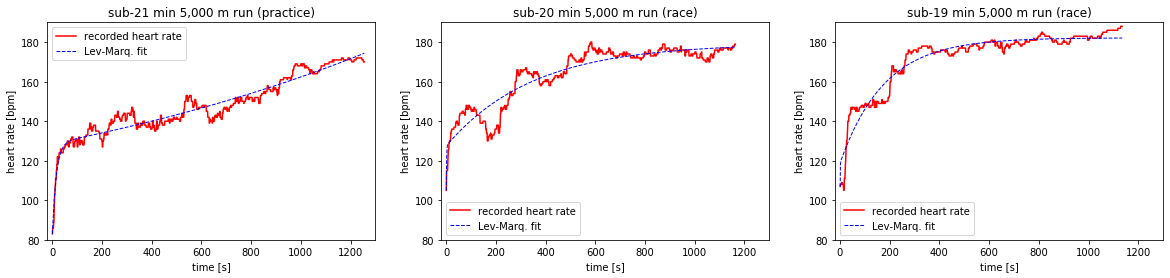

In [28]:
#initial conditions
x1_init = 0
x2_init = 0
initial_conditions = [x1_init, x2_init]

HR_rest_sub_19 = hr_sub_19[0] #reasting heart rate, essentially the heart rate recorded at race start
HR_rest_sub_20 = hr_sub_20[0]
HR_rest_sub_21 = hr_sub_21[0]

#initial parameter guess:
a1 = 2
a2 = 20
a3 = 4e-2
a4 = 2e-3
a5 = 8

params = Parameters()
params.add('a1', value=a1, min=0, max=20)
params.add('a2', value=a2, min=0, max=40)
params.add('a3', value=a3, min=0, max=5)
params.add('a4', value=a4, min=0, max=5)
params.add('a5', value=a5, min=0, max=40)

sub_21_data = np.array(hr_sub_21)-HR_rest_sub_21
sub_21_result = minimize(error, params, args=(initial_conditions, secs_sub_21, sub_21_data), method='leastsq')
sub_21_final_x1 = sub_21_data + sub_21_result.residual.reshape(sub_21_data.shape)

sub_20_data = np.array(hr_sub_20)-HR_rest_sub_20
sub_20_result = minimize(error, params, args=(initial_conditions, secs_sub_20, sub_20_data), method='leastsq')
sub_20_final_x1 = sub_20_data + sub_20_result.residual.reshape(sub_20_data.shape)

sub_19_data = np.array(hr_sub_19)-HR_rest_sub_19
sub_19_result = minimize(error, params, args=(initial_conditions, secs_sub_19, sub_19_data), method='leastsq')
sub_19_final_x1 = sub_19_data + sub_19_result.residual.reshape(sub_19_data.shape)

fig, (plt1, plt2, plt3) = plt.subplots(1, 3, figsize=(20, 4))

plt1.plot(secs_sub_21, hr_sub_21, color="red",label='recorded heart rate')
plt1.plot(secs_sub_21, np.array(sub_21_final_x1)+HR_rest_sub_21, '--', linewidth=1, color='blue',label="Lev-Marq. fit")
plt1.set_xlim([-20,1300])
plt1.set_ylim([80,190])
plt1.set_xlabel("time [s]")
plt1.set_ylabel("heart rate [bpm]")
plt1.set_title("sub-21 min 5,000 m run (practice)")
plt1.legend()

plt2.plot(secs_sub_20, hr_sub_20, color="red",label='recorded heart rate')
plt2.plot(secs_sub_20, np.array(sub_20_final_x1)+HR_rest_sub_20, '--', linewidth=1, color='blue',label="Lev-Marq. fit")
plt2.set_xlim([-20,1300])
plt2.set_ylim([80,190])
plt2.set_xlabel("time [s]")
plt2.set_ylabel("heart rate [bpm]")
plt2.set_title("sub-20 min 5,000 m run (race)")
plt2.legend()

plt3.plot(secs_sub_19, hr_sub_19, color="red",label='recorded heart rate')
plt3.plot(secs_sub_19, np.array(sub_19_final_x1)+HR_rest_sub_19, '--', linewidth=1, color='blue',label="Lev-Marq. fit")
plt3.set_xlim([-20,1300])
plt3.set_ylim([80,190])
plt3.set_xlabel("time [s]")
plt3.set_ylabel("heart rate [bpm]")
plt3.set_title("sub-19 min 5,000 m run (race)")
plt3.legend()
